<div class="usecase-title">Ideal Green Wall Locations</div>

<div class="usecase-authors"><b>Authored by: </b>Alison Collins</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Data Preprocessing, Data Analysis</div>
</div>

<div class="usecase-section-header">Scenario</div>

1. As an ecologist, I want to increase the biodiversity of flora and fauna life within the city of Melbourne.

2. As a city planner, I need to know the best locations for green walls within the city of Melbourne, where they will have the greatest impact on reducing pollution and increasing fauna numbers.

3. As a resident, I wish to have more green places to aid in my feelings of welbeing within the city.

<div class="usecase-section-header">Background</div>

There is much current emphasis on the increase of green spaces within our cities worldwide. Much research has been done into the benefits of increasing plant life in cities, with findings showing green spaces <a href="#fn-1">[1]</a>: 
- allow greater oxygen production for fresh air to breathe
- provide increased storage ability to store carbon dioxide, helping reduce green house gases
- swell evapotranspiration, which produces a cooling effect that assists in reducing heat waves
- provide habitats for wildlife
- reduce cortisol, improving mental health and wellbeing of city dwellers

Green walls provide a solution to the lack of space in cities for additional green spaces. Green walls are also called vertical gardens and are made up of plants growing directly up a wall or in a supporting structure attached to a wall. In addition to the known benefits of increasing plant numbers, green walls have also been found to assist with temperature control and reduce noise pollution within the buildings they are attached to <a href="#fn-2">[2]</a>.

The planting of green walls aligns with the City of Melbourne’s Nature in the City Strategy and Urban Forest Strategy <a href="#fn-3">[3]</a>. Programs such as the Greening the City Project and Green Yout Laneway program can both be supported by identifying the optimal locations for green walls.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Import data using API v2.1 GET request with /exports extension
- Import libraries, check for missing /null values in order to have a clean dataset
- Data visualisation by using matplotlib, dataframes, Geopandas
- Convert between Geodataframes and dataframes
- Use Geopandas to take subsamples of Geodataframes
- Allow user input
- Resample dataframes using date_time
- Mapping with folium incuding custom markers
- Oversampling, Undersampling and bootstrap approaches for imbalanced data classes
- Predictive modelling with Logistic Regression and Random Forest
- Understand results of confusion matrix, accuracy score and classification reports

<div class="usecase-section-header">Relevant Datasets</div>

REQUIRED MODULES

In [1]:
# Import dependencies
import warnings
warnings.filterwarnings("ignore")

import requests
import pandas as pd
pd.set_option('display.max_columns', None)
from io import StringIO

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

## Microclimate sensor readings

In [2]:
#Function to collect data using API v 2.1
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = api_key #use if use datasets require API_key permissions
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey  #use if datasets require API_key permissions
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [3]:
# IMPORT MICROCLIMATE SENSOR READINGS DATASET
# Set dataset_id to query for the API call dataset name
dataset_id = 'microclimate-sensor-readings'
# Save dataset to df varaible
micro_data = collect_data(dataset_id)
# Check number of records in df
print(f'The dataset contains {len(micro_data)} records.')
# View df
micro_data.head(3)

The dataset contains 56 records.


local_time       id  site_id sensor_id    value  \
0  2023-11-29T22:15:02+00:00  8110553     1011        5b    74.38   
1  2023-11-29T22:15:02+00:00  8110558     1011        5c  1010.80   
2  2023-11-29T22:15:03+00:00  8110562     1011         6     0.00   

           type units gatewayhub_id site_status  
0        TPH.RH     %       arc1055           C  
1  TPH.PRESSURE   hPa       arc1055           C  
2            WS  km/h       arc1055           C

In [4]:
# Convert local time in micro dataframe to a datetime datatype
micro_data['local_time'] = pd.to_datetime(micro_data['local_time'] )
micro_data['local_time'].dtypes

datetime64[ns, UTC]

##### Investigate the measurements of Particulate Matter 10ug/m^3 in size at each location

PM10 are common air pollutant particles in the size of 0.01mm or smaller. PM10 particles can impact the health of people living in Melbourne city, particularly those with heart or lung conditions <a href="#fn-4">[4]</a> .

In [5]:
# Make a dataframe with only the PM10 values
micro_PM10 = micro_data.loc[micro_data['type'] == 'PM10']
micro_PM10.shape

(12, 9)

In [6]:
# Check the ids of different sites PM10 values were recorded at
micro_PM10['site_id'].unique()

array([1009, 1011, 1012], dtype=int64)

In [7]:
# Split the PM10 dataframe into 3 dataframes, one for each site
site_ids = [1011, 1012, 1009]
site_dfs = []

for site_id in site_ids:
    # Select site id from list, add only values form one site id to side_id dataframe
    site_df = micro_PM10.loc[micro_PM10['site_id'] == site_id]
    # Sort values into time order
    site_df = site_df.sort_values(by='local_time')
    # Select only the local_time and value variables from the dataframe
    site_df = site_df[['local_time', 'value']]
    # Set local time to datetime object
    site_df['local_time'] = pd.to_datetime(site_df['local_time'] )
    # Round time time nearest minute
    site_df["local_time"] = site_df["local_time"].dt.floor('1min')
    # Add site_df to the dataframe
    site_dfs.append(site_df)
    
site1011_10 = site_dfs[0]
site1012_10 = site_dfs[1]
site1009_10 = site_dfs[2]

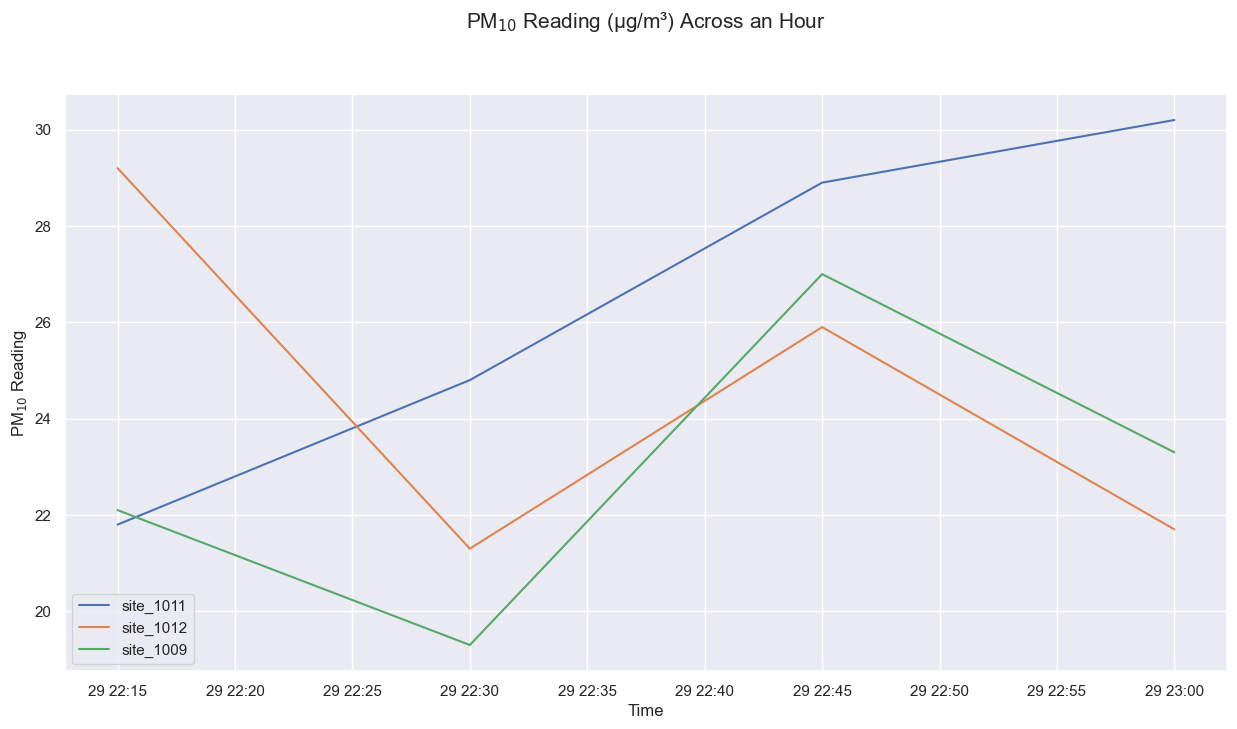

In [8]:
# Plot the PM10 readings over time
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(site1011_10['local_time'], site1011_10['value'], label = 'site_1011')
ax.plot(site1012_10['local_time'], site1012_10['value'], label = 'site_1012')
ax.plot(site1009_10['local_time'], site1009_10['value'], label = 'site_1009')

ax.set_xlabel("Time")
ax.set_ylabel("PM$_{10}$ Reading")
ax.set_title("PM$_{10}$ Reading (µg/m\u00b3) Across an Hour", y=1.1, fontsize=15)

plt.legend()
plt.show()

 Three sites had measurements of PM10 recorded over an hour period. All sites show PM10 values at a range between 19ug/m3 and 30ug/m3 at the time of measurement. Site 1012 recorded the lowest measurement, 19ug/m3, at 10:30pm and site 1011 recorded the highest value of 30.5ug/m3 at 11pm.

##### Investigate the measurements of Particulate Matter 2.5ug/m^3 in size at each location

PM2.5 are also air pollutant particles, commonly found in smoke. They have a size of 0.0025mm or smaller. PM2.5 particles can impact the health of people living in Melbourne city, but are of greater concern than PM10 particles as PM2.5 can penetrate deep in the lungs and make their way into the bloodstream of people exposed to them <a href="#fn-5">[5]</a> .

In [9]:
# Make a dataframe with only the PM2.5 values
micro_PM2_5 = micro_data.loc[micro_data['type'] == 'PM2.5']
micro_PM2_5.shape

(12, 9)

In [10]:
# Split the PM2.5 dataframe into 3 dataframes, one for each site
site_ids = [1011, 1012, 1009]
site_dfs = []

for site_id in site_ids:
    # Select site id from list, add only values form one site id to side_id dataframe
    site_df = micro_PM2_5.loc[micro_PM2_5['site_id'] == site_id]
    # Sort values into time order
    site_df = site_df.sort_values(by='local_time')
    # Select only the local_time and value variables from the dataframe
    site_df = site_df[['local_time', 'value']]
    # Set local time to datetime object
    site_df['local_time'] = pd.to_datetime(site_df['local_time'] )
    # Round time time nearest minute
    site_df["local_time"] = site_df["local_time"].dt.floor('1min')
    # Add site_df to the dataframe
    site_dfs.append(site_df)
    
site1011_2_5 = site_dfs[0]
site1012_2_5 = site_dfs[1]
site1009_2_5 = site_dfs[2]

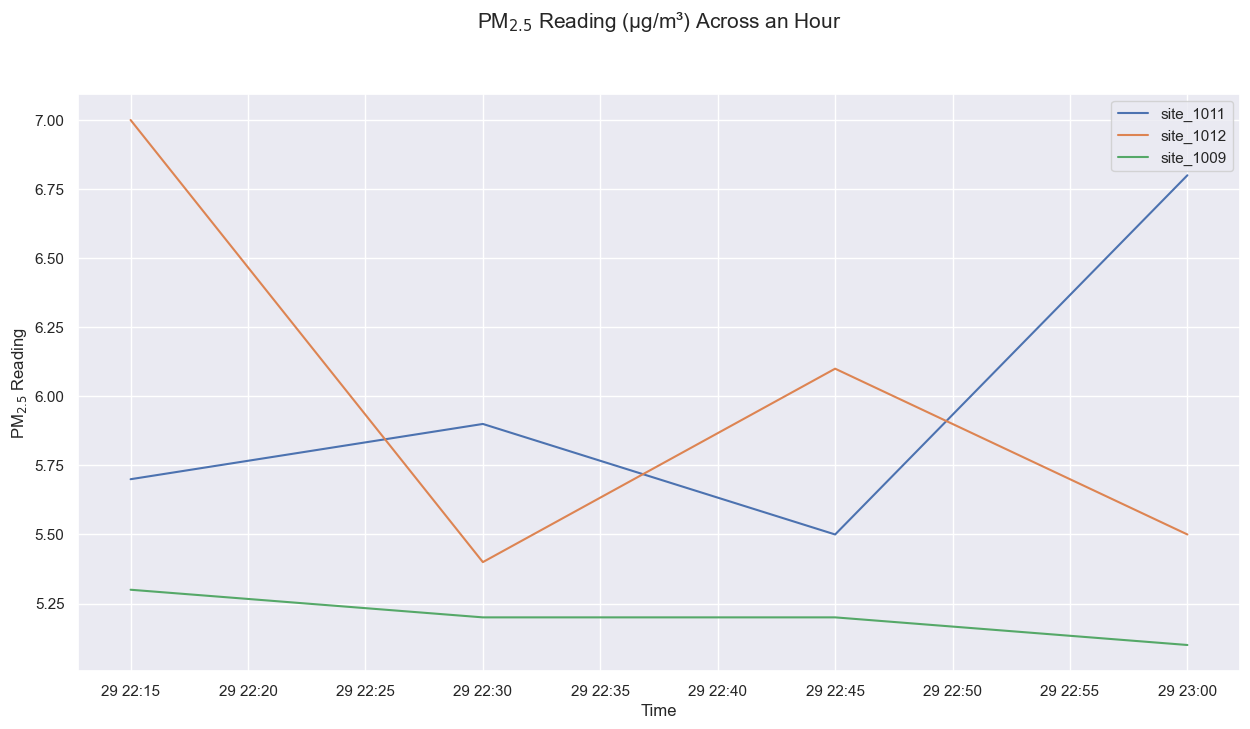

In [11]:
# Plot the PM2.5 readings over time
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(site1011_2_5['local_time'], site1011_2_5['value'], label = 'site_1011')
ax.plot(site1012_2_5['local_time'], site1012_2_5['value'], label = 'site_1012')
ax.plot(site1009_2_5['local_time'], site1009_2_5['value'], label = 'site_1009')

ax.set_xlabel("Time")
ax.set_ylabel("PM$_{2.5}$ Reading")
ax.set_title("PM$_{2.5}$ Reading (µg/m\u00b3) Across an Hour", y=1.1, fontsize=15)

plt.legend()
plt.show()

 The same three sites had measurements of PM2.5 recorded over an hour period. Site 1109 has the lowest range in PM2.5 measurements, with all times recording values close to 5.25ug/m3. Sites 1011 and 1012 show PM2.5 values at a range between 5.4ug/m3 and 7ug/m3 at the time of measurement. The highest value recorded was 7ug/m3 at 10:15pm at site 1012.

##### View the average hourly particulate matter at each site

The EPA AirWatch uses air quality categories to assess air quality. These categories are based on particle count numbers on average per hour and per day. As there is only an hour of data availible, the daily average can be categorised for each location.

In [33]:
# For PM10 data
# Select the necessary rows only
mini_micro_PM10 = micro_PM10[['site_id','value']]
# Group by site id and find the mean of each group
mini_micro_PM10 = mini_micro_PM10.groupby(['site_id']).mean().reset_index()
# Convert site ids to strings
mini_micro_PM10['site_id'] = mini_micro_PM10['site_id'].astype('string')

In [34]:
# For PM2.5 data
# Select the necessary rows only
mini_micro_PM2_5 = micro_PM2_5[['site_id','value']]
# Group by site id and find the mean of each group
mini_micro_PM2_5 = mini_micro_PM2_5.groupby(['site_id']).mean().reset_index()
# Convert site ids to strings
mini_micro_PM2_5['site_id'] = mini_micro_PM2_5['site_id'].astype('string')


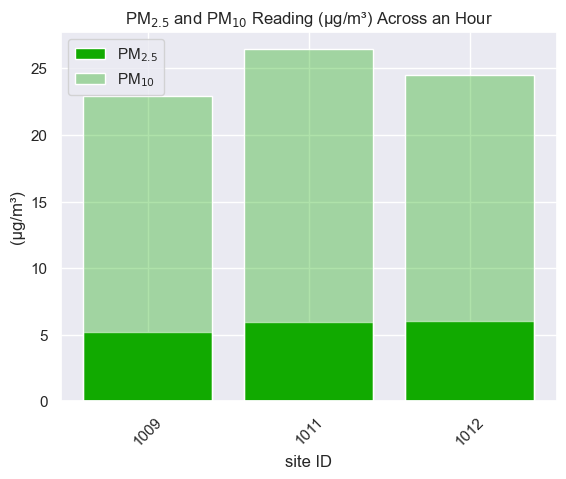

In [35]:
# Bar plot of PM2.5 and PM10 data
plt.bar(mini_micro_PM2_5['site_id'],mini_micro_PM2_5['value'], color="#1a0", label="PM$_{2.5}$") 
plt.bar(mini_micro_PM10['site_id'],mini_micro_PM10['value'], color="#1a05", label="PM$_{10}$") 
plt.title('PM$_{2.5}$ and PM$_{10}$ Reading (µg/m\u00b3) Across an Hour')
plt.xlabel('site ID')
plt.xticks(rotation=45)
plt.ylabel('(µg/m\u00b3)')
plt.legend()
plt.show()

The average PM2.5 reading hovers around 5.25 at all sites. The EPA categorises this level as good air quality, as it is less than 25 ug/m3 <a href="#fn-5">[5]</a>. The average PM10 score is between 23ug/m3 and 27ug/m3 at all sites. This is also categorised as good air quality as it is below the threshold of 40ug/m3 <a href="#fn-4">[4]</a>.

## Microclimate sensor locations 

It would be useful to identify the sensor locations on a map, so an additional dataset will need to be loaded and combined to view this.

In [36]:
# IMPORT MICROCLIMATE SENSOR LOCATIONS DATASET
# Set dataset_id to query for the API call dataset name
dataset_id = 'microclimate-sensor-locations'
# Save dataset to df varaible
micro_loc = collect_data(dataset_id)
# Check number of records in df
print(f'The dataset contains {len(micro_loc)} records.')
# View df
micro_loc.head(3)

The dataset contains 16 records.


site_id gatewayhub_id site_status  last_data_local start_reading  \
0     1004       arc1048           R              NaN    2019-11-15   
1     1006       arc1112           R              NaN    2021-05-20   
2     1011       arc1055           C              NaN    2021-07-07   

  end_reading   latitude   longitude                location  
0  2021-06-13 -37.800575  144.964635  -37.800575, 144.964635  
1  2021-06-28 -37.822486  144.952065  -37.822486, 144.952065  
2         NaN -37.822222  144.952222  -37.822222, 144.952222

In [39]:
# Merging sensor location data with sensor reading data.
# Merge dataframes on site_id value
micro = pd.merge(micro_data, micro_loc, on='site_id')
# Drop duplicates and columsn with NaN data
micro = micro.drop(['gatewayhub_id_y', 'end_reading', 'last_data_local', 'site_status_y'], axis=1)
# Automatically convert datatypes based on column values
micro = micro.convert_dtypes()
# Drop retired sensors
micro = micro[micro['site_status_x'] != 'R']
micro.head(3)

local_time       id  site_id sensor_id   value          type  \
0 2023-11-29 22:15:02+00:00  8110553     1011        5b   74.38        TPH.RH   
1 2023-11-29 22:15:02+00:00  8110558     1011        5c  1010.8  TPH.PRESSURE   
2 2023-11-29 22:15:03+00:00  8110562     1011         6     0.0            WS   

  units gatewayhub_id_x site_status_x start_reading   latitude   longitude  \
0     %         arc1055             C    2021-07-07 -37.822222  144.952222   
1   hPa         arc1055             C    2021-07-07 -37.822222  144.952222   
2  km/h         arc1055             C    2021-07-07 -37.822222  144.952222   

                 location  
0  -37.822222, 144.952222  
1  -37.822222, 144.952222  
2  -37.822222, 144.952222

In [40]:
# Get unique locations from microdata
micro_loc = micro.drop_duplicates(subset=['site_id'])
# Convert to geo-dataframe
gdf_micro_loc = gpd.GeoDataFrame(micro_loc, geometry=gpd.points_from_xy(micro_loc['latitude'], micro_loc['longitude']))
gdf_micro_loc.head(3)

local_time       id  site_id sensor_id  value    type  \
0  2023-11-29 22:15:02+00:00  8110553     1011        5b  74.38  TPH.RH   
24 2023-11-29 22:15:04+00:00  8110606     1012         6    0.0      WS   
48 2023-11-29 22:15:11+00:00  8110489     1009        0a    5.3   PM2.5   

     units gatewayhub_id_x site_status_x start_reading   latitude   longitude  \
0        %         arc1055             C    2021-07-07 -37.822222  144.952222   
24    km/h         arc1048             C    2021-09-17 -37.813333      144.97   
48  ug/m^3         arc1050             C    2021-06-14 -37.816868  144.965705   

                      location                 geometry  
0       -37.822222, 144.952222  POINT (-37.822 144.952)  
24          -37.813333, 144.97  POINT (-37.813 144.970)  
48  -37.81686763, 144.96570467  POINT (-37.817 144.966)

In [44]:
# Initialize the map at Melbourne and store it in a m object
m = folium.Map(location = [-37.815, 144.96],zoom_start = 14)

# Add bus stop locations
for i in range(0,len(gdf_micro_loc)):
   folium.Marker(
      location=[gdf_micro_loc.iloc[i]['latitude'], gdf_micro_loc.iloc[i]['longitude']],
      popup=gdf_micro_loc.iloc[i]['site_id'],
      icon=folium.Icon(color="green"),
   ).add_to(m)
   
# Show the map
m

The map shows the location of each of the micro sensors when the info pin is clicked on. Site 1011 is in the Siddelely Street carpark, 1009 is in Flinders Lane and 1012 is on Little Collins Street.

## Pedestrian Counting System (counts per hour)

In [45]:
# IMPORT PEDESTRIAN COUNTS DATASET
# Set dataset_id to query for the API call dataset name
dataset_id = 'pedestrian-counting-system-monthly-counts-per-hour'
# Save dataset to df varaible
ped_count = collect_data(dataset_id)
# Check number of records in df
print(f'The dataset contains {len(ped_count)} records.')
# View df
ped_count.head(3)

The dataset contains 549976 records.


sensor_name                  timestamp  locationid  direction_1  \
0    SprFli_T  2023-04-24T21:00:00+00:00          75           36   
1    SprFli_T  2023-04-25T00:00:00+00:00          75           28   
2    SprFli_T  2023-04-25T01:00:00+00:00          75           63   

   direction_2  total_of_directions                    location  
0           17                   53  -37.81515276, 144.97467661  
1           50                   78  -37.81515276, 144.97467661  
2           63                  126  -37.81515276, 144.97467661

In [46]:
# Pedestrain data pre-processing
# Drop columns not being used
ped_count = ped_count.drop(['sensor_name', 'direction_1', 'direction_2'], axis=1)
# Rename columns
pedest_count = ped_count.rename(columns={'locationid': 'sensor_id', 'total_of_directions': 'hourly_counts'})
# Convert data types
ped_count[[ 'sensor_id', 'hourly_counts']] = pedest_count[['sensor_id', 'hourly_counts']].astype(int)
ped_count = ped_count.convert_dtypes()
# View datatype in each column
ped_count.dtypes

timestamp              string[python]
locationid                      Int64
total_of_directions             Int64
location               string[python]
sensor_id                       Int32
hourly_counts                   Int32
dtype: object

In [47]:
# Plot of average pedestrian counts per sensor
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(ped_count_mean["sensor_id"], ped_count_mean["hourly_counts_mean"], color ='lightseagreen', width = 0.8)
 
plt.xlabel("Sensor number")
plt.ylabel("Mean pedestrians")
plt.title("Averge pedestrian numbers recorded by each sensor")
plt.show()

NameError: name 'ped_count_mean' is not defined

<Figure size 1000x500 with 0 Axes>

## Pedestrian Counting Sensor location

In [19]:
#Dataset name
ped_location_dataset = 'pedestrian-counting-system-sensor-locations'
number_of_records = 100

filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

ped_count_url = f'{base_url_v2}{ped_location_dataset}/{filters}'
ped_count_url

'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/pedestrian-counting-system-sensor-locations/records?limit=100&offset=0&timezone=UTC'

In [20]:
result = requests.get(ped_count_url)
result_json = result.json()
result_json['total_count']

113

In [22]:
pedest_loc = extract_dataframe(ped_location_dataset)

In [23]:
pedest_loc

id                 timestamp size  \
0   97d6ad89c7bad598e920a8ac4f8bf7356d33f596  2023-08-21T15:20:00.504Z  169   
1   37dd097972c7dc3e9f94f0d151490ca835463d36  2023-08-21T15:20:00.504Z  159   
2   8de28584efb0abf0e79c71ec97560108e588a40d  2023-08-21T15:20:00.504Z  200   
3   5f1f33b5b8bf8deb18ca385acfa5a2549b367454  2023-08-21T15:20:00.504Z  153   
4   392d2c94a67571f2b2a9e2f06ad4cdc19d4e3d77  2023-08-21T15:20:00.504Z  158   
..                                       ...                       ...  ...   
8   f9bd8f49d8f4b8c7402c65b0f37880b663d88983  2023-08-21T15:20:00.504Z  172   
9   2669f2f34caa3199bf01c86bdde4754f93f8a660  2023-08-21T15:20:00.504Z  177   
10  08a8c48cfa8363545c520c10d55f14ed13c5fd11  2023-08-21T15:20:00.504Z  162   
11  6c31d0c8fdd354d88f9fe79ff75a92cadc939cf9  2023-08-21T15:20:00.504Z  155   
12  b9abd31ecf94817488a0ec44fda4434f9471a279  2023-08-21T15:20:00.504Z  179   

   location_id                       sensor_description   sensor_name  \
0            2               Bourke Street Mall (South)      Bou283_T   
1            4                         Town Hall (West)      Swa123_T   
2            6        Flinders Street Station Underpass        FliS_T   
3            8                              Webb Bridge       WebBN_T   
4           10                           Victoria Point      BouHbr_T   
..         ...                                      ...           ...   
8          107                 Flagstaff station (East)     280Will_T   
9          109          La Trobe St- William St (South)     LatWill_T   
10         110                Birrarung Marr East Entry     BirBlix_T   
11         120                        Harbour Esplanade    HarbBlix_T   
12         127  Birrarung Marr - Federation Foot Bridge  BirFedBlix_T   

   installation_date                 note location_type status direction_1  \
0         2009-03-30                 None       Outdoor      A        East   
1         2009-03-23                 None       Outdoor      A       North   
2         2009-03-25  Upgraded on 8/09/21       Outdoor      A       North   
3         2009-03-24                 None       Outdoor      A       North   
4         2009-04-23                 None       Outdoor      A        East   
..               ...                  ...           ...    ...         ...   
8         2022-10-08                 None       Outdoor      A       North   
9         2022-10-08                 None       Outdoor      A        East   
10        2021-12-07                 None  Outdoor Blix      A        None   
11        2021-03-25                 None  Outdoor Blix      A        None   
12        2023-03-23                 None  Outdoor Blix      A        None   

   direction_2   latitude   longitude         lon        lat  
0         West -37.813807  144.965167  144.965167 -37.813807  
1        South -37.814880  144.966088  144.966088 -37.814880  
2        South -37.819117  144.965583  144.965583 -37.819117  
3        South -37.822935  144.947175  144.947175 -37.822935  
4         West -37.818765  144.947105  144.947105 -37.818765  
..         ...        ...         ...         ...        ...  
8        South -37.812463  144.956902  144.956902 -37.812463  
9         West -37.811937  144.956211  144.956211 -37.811937  
10        None -37.821029  144.975902  144.975902 -37.821029  
11        None -37.814426  144.944366  144.944366 -37.814426  
12        None -37.818492  144.973672  144.973672 -37.818492  

[113 rows x 16 columns]

In [24]:
# Drop columns not likely to be used
pedest_loc = pedest_loc.drop(['id','timestamp','size', 'note', 'location_type', 'sensor_description', 'direction_1', 'direction_2', 'latitude', 'longitude'], axis=1)

pedest_loc = pedest_loc.rename(columns={'location_id': 'sensor_id'})

# Convert to correct data types
pedest_loc[[ 'sensor_id']] = pedest_loc[['sensor_id']].astype(int)
#pedest_loc[['latitude', 'longitude']] = pedest_loc[['latitude', 'longitude']].astype(float)
pedest_loc['installation_date'] = pd.to_datetime(pedest_loc['installation_date'])
pedest_loc = pedest_loc.convert_dtypes()

pedest_loc.dtypes

sensor_id                     Int32
sensor_name                  string
installation_date    datetime64[ns]
status                       string
lon                         Float64
lat                         Float64
dtype: object

In [25]:
# Merging sensor location data with counting data.
pedest = pd.merge(pedest_mean, pedest_loc, on='sensor_id')
pedest

sensor_id  hourly_counts_mean  sensor_name installation_date status  \
0           1                 839     Bou292_T        2009-03-24      A   
1           2                 442     Bou283_T        2009-03-30      A   
2           3                1003     Swa295_T        2009-03-25      A   
3           4                1290     Swa123_T        2009-03-23      A   
4           5                 943      PriNW_T        2009-03-26      A   
..        ...                 ...          ...               ...    ...   
75        117                 216    Fli114F_T        2022-12-06      A   
76        118                  28    Fli114C_T        2022-12-06      A   
77        122                  70   FedCycle_T        2022-08-23      A   
78        123                  45  BirBridge_T        2023-06-02      A   
79        124                   6  BirBridge_T        2023-06-02      A   

           lon        lat  
0   144.965153 -37.813494  
1   144.965167 -37.813807  
2   144.964295 -37.811015  
3   144.966088  -37.81488  
4   144.967877 -37.818742  
..         ...        ...  
75  144.970909 -37.816293  
76  144.970905 -37.816328  
77  144.971694 -37.818629  
78  144.973297 -37.817537  
79  144.973299 -37.817574  

[80 rows x 7 columns]

In [26]:
import folium
from folium.plugins import MarkerCluster
def map_visualization(data):
    locations = []
    for i in range(len(data)):
        row =data.iloc[i]
        location = [(row.lat,row.lon)]*int(row.hourly_counts_mean)
        locations += location
      
    marker_cluster  = MarkerCluster(
      locations=locations,
      overlay=True,
      control=True,
      )
    m = folium.Map(location=[-37.8167, 144.967], zoom_start=15)
    marker_cluster.add_to(m)

    folium.LayerControl().add_to(m)
    
    m
    return m
map_visualization(pedest)

## Butterfly biodiversity survey and insect data

In [11]:
# Base url for v2 api
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/'

# Dataset name
dataset = 'butterfly-biodiversity-survey-2017' # enter the dataset indentifier here

# A filter at the end of the url
number_of_records = 100
filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

In [27]:
bflydata = extract_dataframe(dataset)

In [28]:
bflydata.drop(bflydata.iloc[:, 0:3], inplace=True, axis=1)
bflydata

site sloc walk        date                       time  \
0       Womens Peace Gardens    2    1  2017-02-26  0001-01-01T11:42:00+00:00   
1              Argyle Square    1    1  2017-11-02  0001-01-01T10:30:00+00:00   
2              Argyle Square    2    1  2017-12-01  0001-01-01T10:35:00+00:00   
3              Westgate Park    4    1  2017-03-03  0001-01-01T11:44:00+00:00   
4              Argyle Square    1    3  2017-01-15  0001-01-01T12:33:00+00:00   
..                       ...  ...  ...         ...                        ...   
51  Fitzroy-Treasury Gardens    3    2  2017-06-02  0001-01-01T17:44:00+00:00   
52             Westgate Park    4    2  2017-02-02  0001-01-01T13:57:00+00:00   
53             Westgate Park    5    3  2017-06-03  0001-01-01T15:43:00+00:00   
54             Westgate Park    4    1  2017-02-02  0001-01-01T11:05:00+00:00   
55     Carlton Gardens South    3    1  2017-01-30  0001-01-01T12:42:00+00:00   

    vegwalktime              vegspecies         vegfamily      lat       lon  \
0        1.3128           Schinus molle     Anacardiaceae -37.7912  144.9244   
1        0.3051  Rosmarinus officinalis         Lamiaceae -37.8023  144.9665   
2        0.3620           Euphorbia sp.     Euphorbiaceae -37.8026  144.9665   
3        3.1585    Melaleuca lanceolata         Myrtaceae -37.8316  144.9089   
4        0.4432              Mentha sp.         Lamiaceae -37.8027  144.9662   
..          ...                     ...               ...      ...       ...   
51       0.5132             Tagetes sp.        Asteraceae -37.8136  144.9819   
52       2.1947    Myoporum parvifolium  Scrophulariaceae -37.8311  144.9092   
53       4.2408        Cassinia arcuata        Asteraceae -37.8299  144.9106   
54       1.5948    Xerochrysum viscosum        Asteraceae -37.8316  144.9093   
55       1.4437            Asteraceae 1        Asteraceae -37.8044  144.9704   

    ...  brow  csem  aand  jvil  paur  ogyr  gmac                   datetime  \
0   ...     0     0     0     0     0     0     0  2017-02-26T11:42:00+00:00   
1   ...     0     0     0     0     0     0     0  2017-02-11T10:30:00+00:00   
2   ...     0     0     0     0     0     0     0  2017-01-12T10:35:00+00:00   
3   ...     0     0     0     0     0     0     0  2017-03-03T11:44:00+00:00   
4   ...     0     0     0     0     0     0     0  2017-01-15T12:33:00+00:00   
..  ...   ...   ...   ...   ...   ...   ...   ...                        ...   
51  ...     0     0     0     0     0     0     0  2017-02-06T17:44:00+00:00   
52  ...     0     0     0     0     0     0     0  2017-02-02T13:57:00+00:00   
53  ...     0     0     0     0     0     0     0  2017-03-06T15:43:00+00:00   
54  ...     0     0     0     0     0     0     0  2017-02-02T11:05:00+00:00   
55  ...     0     0     0     0     0     0     0  2017-01-30T12:42:00+00:00   

         lon      lat  
0   144.9244 -37.7912  
1   144.9665 -37.8023  
2   144.9665 -37.8026  
3   144.9089 -37.8316  
4   144.9662 -37.8027  
..       ...      ...  
51  144.9819 -37.8136  
52  144.9092 -37.8311  
53  144.9106 -37.8299  
54  144.9093 -37.8316  
55  144.9704 -37.8044  

[4056 rows x 43 columns]

In [29]:
#Aggregating the butterfly data as count of individual species by monitoring location.
bflyCounts = bflydata.groupby(["site"])["site"].count().reset_index(name="Butterfly Species Count")
bflyCounts.insert(0, 'id', range(1, 1 + len(bflyCounts)))
bflyCounts

id                       site  Butterfly Species Count
0    1              Argyle Square                      256
1    2   Canning/Neill St Reserve                       40
2    3      Carlton Gardens South                      592
3    4   Fitzroy-Treasury Gardens                      572
4    5           Gardiner Reserve                       28
5    6     Garrard Street Reserve                       44
6    7             Lincoln Square                      124
7    8          Murchinson Square                       52
8    9          Pleasance Gardens                       56
9   10               Princes Park                      224
10  11                 Royal Park                     1152
11  12  State Library of Victoria                       84
12  13          University Square                       24
13  14              Westgate Park                      588
14  15       Womens Peace Gardens                      220

In [18]:
insectdata = extract_dataframe("insect-records-in-the-city-of-melbourne-from-little-things-that-run-the-city")

In [30]:
insectdata.drop(insectdata.iloc[:, 0:3], inplace=True, axis=1)
insectdata

taxa   kingdom      phylum    class       order         family  \
0   Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
1   Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
2   Insect  ANIMALIA  ARTHROPODA  INSECTA   HEMIPTERA      PSYLLIDAE   
3   Insect  ANIMALIA  ARTHROPODA  INSECTA   HEMIPTERA        MIRIDAE   
4   Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA  COCCINELLIDAE   
..     ...       ...         ...      ...         ...            ...   
90  Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
91  Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
92  Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
93  Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
94  Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   

           genus      species identification_notes  \
0    Cortinicara         None     Cortinicara sp.1   
1    Cortinicara         None     Cortinicara sp.1   
2         Creiis         None         Creiis sp. 1   
3    Creontiades      dilutus                 None   
4   Cryptolaemus  montrouzeri                 None   
..           ...          ...                  ...   
90    Corticaria         None      Corticaria sp.1   
91   Cortinicara         None     Cortinicara sp.1   
92   Cortinicara         None     Cortinicara sp.1   
93   Cortinicara         None     Cortinicara sp.1   
94   Cortinicara         None     Cortinicara sp.1   

                       location sighting_date  
0                    Royal Park          None  
1                 Westgate Park          None  
2                    Royal Park          None  
3                Lincoln Square          None  
4     State Library of Victoria          None  
..                          ...           ...  
90                 Princes Park          None  
91  Canning/Neil Street Reserve          None  
92            Murchinson Square          None  
93            Pleasance Gardens          None  
94                 Princes Park          None  

[1295 rows x 11 columns]

In [32]:
#Aggregating the insect data as count of individual species by monitoring location.
insectCounts = insectdata.groupby(["location"])["location"].count().reset_index(name="Miscellaneous Insect Count")

#Creating id index
insectCounts.insert(0, 'id', range(1, 1 + len(insectCounts)))

# Renaming the monitoring location column to something more intuitive.
insectCounts = insectCounts.rename({'location': 'Location'}, axis=1) 

insectCounts

id                     Location  Miscellaneous Insect Count
0    1                Argyle Square                          43
1    2  Canning/Neil Street Reserve                          14
2    3        Carlton Gardens South                          97
3    4     Fitzroy-Treasury Gardens                         150
4    5             Gardiner Reserve                          24
5    6       Garrard Street Reserve                          26
6    7               Lincoln Square                          37
7    8            Murchinson Square                          14
8    9            Pleasance Gardens                          42
9   10                 Princes Park                         177
10  11                   Royal Park                         354
11  12    State Library of Victoria                          51
12  13            University Square                          26
13  14                Westgate Park                         186
14  15        Women's Peace Gardens                          54

In [35]:
#Creating point data shapefile to align with the monitoring locations. Coordinates taken from external mapping software (QGIS).

insectCoords = pd.DataFrame({'longitude': [2496990.9139893204, 2497716.4106032336, 2497468.0019974816,2497904.2864259947,2495048.0358508285,2494903.373709257,2496730.7911691167,2497631.1602672394,2495215.229639408,2496593.58352767,
                                 2495657.343150738,2496862.1697277585,2496501.887571214,2491904.086409784,2493312.0341030643], 
                   
                   'latitude': [2410917.9145240453, 2411981.946331717, 2410514.362637444,2409637.309870564,2411319.224455721,2413521.833072339,2410956.1398554766,2411196.477423501,2411624.2424233076,2412883.3243095265,
                                2412807.994624026,2410110.0260665533,2411092.4507149556,2407712.4794691135,2412201.7700121445]})

insectCounts['geometry'] = gpd.points_from_xy(insectCoords.longitude, insectCoords.latitude, crs="EPSG:3111")

insectCounts

id                     Location  Miscellaneous Insect Count  \
0    1                Argyle Square                          43   
1    2  Canning/Neil Street Reserve                          14   
2    3        Carlton Gardens South                          97   
3    4     Fitzroy-Treasury Gardens                         150   
4    5             Gardiner Reserve                          24   
5    6       Garrard Street Reserve                          26   
6    7               Lincoln Square                          37   
7    8            Murchinson Square                          14   
8    9            Pleasance Gardens                          42   
9   10                 Princes Park                         177   
10  11                   Royal Park                         354   
11  12    State Library of Victoria                          51   
12  13            University Square                          26   
13  14                Westgate Park                         186   
14  15        Women's Peace Gardens                          54   

                           geometry  
0   POINT (2496990.914 2410917.915)  
1   POINT (2497716.411 2411981.946)  
2   POINT (2497468.002 2410514.363)  
3   POINT (2497904.286 2409637.310)  
4   POINT (2495048.036 2411319.224)  
5   POINT (2494903.374 2413521.833)  
6   POINT (2496730.791 2410956.140)  
7   POINT (2497631.160 2411196.477)  
8   POINT (2495215.230 2411624.242)  
9   POINT (2496593.584 2412883.324)  
10  POINT (2495657.343 2412807.995)  
11  POINT (2496862.170 2410110.026)  
12  POINT (2496501.888 2411092.451)  
13  POINT (2491904.086 2407712.479)  
14  POINT (2493312.034 2412201.770)

In [36]:
#Adding butterfly data to insect data.
insectCounts = pd.merge(left=insectCounts, right=bflyCounts, how='left', left_on='id', right_on='id')
insectCounts = insectCounts.drop(['site'], axis=1)

#Summing counts of misc. insects and butterflies.
insectCounts['Total Insect Count'] = insectCounts["Miscellaneous Insect Count"] + insectCounts["Butterfly Species Count"]

#Converting dataframe to geopandas format.
insectCounts = gpd.GeoDataFrame(insectCounts, geometry='geometry')

insectCounts

id                     Location  Miscellaneous Insect Count  \
0    1                Argyle Square                          43   
1    2  Canning/Neil Street Reserve                          14   
2    3        Carlton Gardens South                          97   
3    4     Fitzroy-Treasury Gardens                         150   
4    5             Gardiner Reserve                          24   
5    6       Garrard Street Reserve                          26   
6    7               Lincoln Square                          37   
7    8            Murchinson Square                          14   
8    9            Pleasance Gardens                          42   
9   10                 Princes Park                         177   
10  11                   Royal Park                         354   
11  12    State Library of Victoria                          51   
12  13            University Square                          26   
13  14                Westgate Park                         186   
14  15        Women's Peace Gardens                          54   

                           geometry  Butterfly Species Count  \
0   POINT (2496990.914 2410917.915)                      256   
1   POINT (2497716.411 2411981.946)                       40   
2   POINT (2497468.002 2410514.363)                      592   
3   POINT (2497904.286 2409637.310)                      572   
4   POINT (2495048.036 2411319.224)                       28   
5   POINT (2494903.374 2413521.833)                       44   
6   POINT (2496730.791 2410956.140)                      124   
7   POINT (2497631.160 2411196.477)                       52   
8   POINT (2495215.230 2411624.242)                       56   
9   POINT (2496593.584 2412883.324)                      224   
10  POINT (2495657.343 2412807.995)                     1152   
11  POINT (2496862.170 2410110.026)                       84   
12  POINT (2496501.888 2411092.451)                       24   
13  POINT (2491904.086 2407712.479)                      588   
14  POINT (2493312.034 2412201.770)                      220   

    Total Insect Count  
0                  299  
1                   54  
2                  689  
3                  722  
4                   52  
5                   70  
6                  161  
7                   66  
8                   98  
9                  401  
10                1506  
11                 135  
12                  50  
13                 774  
14                 274

## Canopy

In [127]:
canopies = extract_dataframe("tree-canopies-2019")

In [128]:
canopies.drop(canopies.iloc[:, 0:3], inplace=True, axis=1)
canopies

lon        lat     type  \
0   144.956620 -37.803398  Feature   
1   144.955416 -37.803382  Feature   
2   144.946449 -37.803232  Feature   
3   144.962095 -37.803477  Feature   
4   144.936249 -37.803047  Feature   
..         ...        ...      ...   
95  144.973369 -37.825027  Feature   
96  144.928138 -37.824240  Feature   
97  144.945012 -37.824533  Feature   
98  144.928501 -37.824244  Feature   
99  144.911201 -37.823888  Feature   

                                          coordinates     type  
0   [[[144.9566248325, -37.8034144011], [144.95662...  Polygon  
1   [[[144.955418644, -37.803393464900005], [144.9...  Polygon  
2   [[[144.9464588306, -37.8032375595], [144.94645...  Polygon  
3   [[[144.9620886681, -37.8034910604], [144.96209...  Polygon  
4   [[[144.9362505352, -37.8030523398], [144.93625...  Polygon  
..                                                ...      ...  
95  [[[144.973365932, -37.825025559], [144.9733659...  Polygon  
96  [[[144.9281366075, -37.8242405779], [144.92813...  Polygon  
97  [[[144.94501369, -37.8245341104], [144.9450137...  Polygon  
98  [[[144.9284972031, -37.82424467], [144.9284986...  Polygon  
99  [[[144.9112088006, -37.823939219], [144.911208...  Polygon  

[9900 rows x 5 columns]

In [129]:
def row_to_geometry(row):
    return Polygon(row['coordinates'][0])



canopies['geometry'] = canopies.apply(row_to_geometry, axis=1)
canopies = gpd.GeoDataFrame(canopies, geometry='geometry')

In [130]:
canopies

lon        lat     type  \
0   144.956620 -37.803398  Feature   
1   144.955416 -37.803382  Feature   
2   144.946449 -37.803232  Feature   
3   144.962095 -37.803477  Feature   
4   144.936249 -37.803047  Feature   
..         ...        ...      ...   
95  144.973369 -37.825027  Feature   
96  144.928138 -37.824240  Feature   
97  144.945012 -37.824533  Feature   
98  144.928501 -37.824244  Feature   
99  144.911201 -37.823888  Feature   

                                          coordinates     type  \
0   [[[144.9566248325, -37.8034144011], [144.95662...  Polygon   
1   [[[144.955418644, -37.803393464900005], [144.9...  Polygon   
2   [[[144.9464588306, -37.8032375595], [144.94645...  Polygon   
3   [[[144.9620886681, -37.8034910604], [144.96209...  Polygon   
4   [[[144.9362505352, -37.8030523398], [144.93625...  Polygon   
..                                                ...      ...   
95  [[[144.973365932, -37.825025559], [144.9733659...  Polygon   
96  [[[144.9281366075, -37.8242405779], [144.92813...  Polygon   
97  [[[144.94501369, -37.8245341104], [144.9450137...  Polygon   
98  [[[144.9284972031, -37.82424467], [144.9284986...  Polygon   
99  [[[144.9112088006, -37.823939219], [144.911208...  Polygon   

                                             geometry  
0   POLYGON ((144.95662 -37.80341, 144.95662 -37.8...  
1   POLYGON ((144.95542 -37.80339, 144.95542 -37.8...  
2   POLYGON ((144.94646 -37.80324, 144.94646 -37.8...  
3   POLYGON ((144.96209 -37.80349, 144.96209 -37.8...  
4   POLYGON ((144.93625 -37.80305, 144.93625 -37.8...  
..                                                ...  
95  POLYGON ((144.97337 -37.82503, 144.97337 -37.8...  
96  POLYGON ((144.92814 -37.82424, 144.92814 -37.8...  
97  POLYGON ((144.94501 -37.82453, 144.94501 -37.8...  
98  POLYGON ((144.92850 -37.82424, 144.92850 -37.8...  
99  POLYGON ((144.91121 -37.82394, 144.91121 -37.8...  

[9900 rows x 6 columns]

In [131]:
canopies = canopies.set_crs("EPSG:4326")
print(canopies.crs)

EPSG:4326


In [132]:
#Creating circles (buffers) of 50m and 100m radius around the insect monitoring locations. These will be combined with the tree canopy data to determine relationship between canopy and insect variety.

insectBuffer50 = insectCounts.buffer(50)
insectBuffer100 = insectCounts.buffer(100)
insectBuffer200 = insectCounts.buffer(200)

insectBuffer50 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer50))
insectBuffer100 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer100))
insectBuffer200 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer200))

insectBuffer50.insert(0, 'id', range(1, 1 + len(insectBuffer50)))
insectBuffer100.insert(0, 'id', range(1, 1 + len(insectBuffer100)))
insectBuffer200.insert(0, 'id', range(1, 1 + len(insectBuffer200)))

#Creating areas of canopy around insect monitoring locations. Note may need to install rtree to enable the overlay operation.
insectCanopies50 = canopies.to_crs(3577).overlay(insectBuffer50.to_crs(3577), how='intersection')
insectCanopies100 = canopies.to_crs(3577).overlay(insectBuffer100.to_crs(3577), how='intersection')
insectCanopies200 = canopies.to_crs(3577).overlay(insectBuffer200.to_crs(3577), how='intersection')

print(insectCanopies50)


C:\Users\playroommountains\AppData\Local\Temp\ipykernel_6904\4059564646.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  insectBuffer50 = insectCounts.buffer(50)
C:\Users\playroommountains\AppData\Local\Temp\ipykernel_6904\4059564646.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  insectBuffer100 = insectCounts.buffer(100)
C:\Users\playroommountains\AppData\Local\Temp\ipykernel_6904\4059564646.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  insectBuffer200 = insectCounts.buffer(200)


Empty GeoDataFrame
Columns: [lon, lat, type, type, coordinates, type, type, id, geometry]
Index: []


In [133]:
insectCounts_projected = insectCounts.to_crs(3577)

insectBuffer50 = insectCounts_projected.buffer(50)
insectBuffer100 = insectCounts_projected.buffer(100)
insectBuffer200 = insectCounts_projected.buffer(200)

insectBuffer50 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer50))
insectBuffer100 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer100))
insectBuffer200 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer200))

insectBuffer50.insert(0, 'id', range(1, 1 + len(insectBuffer50)))
insectBuffer100.insert(0, 'id', range(1, 1 + len(insectBuffer100)))
insectBuffer200.insert(0, 'id', range(1, 1 + len(insectBuffer200)))

# Since both canopies and insectBuffers are now in the same CRS (EPSG:3577), you can proceed with the overlay operation
insectCanopies50 = canopies.to_crs(3577).overlay(insectBuffer50, how='intersection')
insectCanopies100 = canopies.to_crs(3577).overlay(insectBuffer100, how='intersection')
insectCanopies200 = canopies.to_crs(3577).overlay(insectBuffer200, how='intersection')

print(insectCanopies50)


C:\Users\playroommountains\anaconda3\lib\site-packages\geopandas\array.py:968: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
C:\Users\playroommountains\anaconda3\lib\site-packages\geopandas\array.py:969: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
C:\Users\playroommountains\anaconda3\lib\site-packages\geopandas\array.py:970: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
C:\Users\playroommountains\anaconda3\lib\site-packages\geopandas\array.py:971: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


Empty GeoDataFrame
Columns: [lon, lat, type, type, coordinates, type, type, id, geometry]
Index: []


In [134]:
#Calculating the area of canopy cover and adding it as a variable.

insectCanopies50['area'] = insectCanopies50['geometry'].area
insectCanopies100['area'] = insectCanopies100['geometry'].area
insectCanopies200['area'] = insectCanopies200['geometry'].area

In [135]:
#Summing canopy area by insect study location.
insectCanopies50 = insectCanopies50.groupby(["id_2"], as_index=False)["area"].sum()
insectCanopies100 = insectCanopies100.groupby(["id_2"], as_index=False)["area"].sum()
insectCanopies200 = insectCanopies200.groupby(["id_2"], as_index=False)["area"].sum()

KeyError: 'id_2'

##### References

<fn id="fn-1">[1]</fn> Trees For Cities (2023) [Trees in out cities: 10 reasons we need to plant more](https://www.treesforcities.org/stories/trees-in-our-cities-10-reasons-we-need-to-plant-more). Trees For Cities, England. 

<fn id="fn-2">[2]</fn> Peter Irga (2020) [Green walls: it's time to grow up](https://www.uts.edu.au/research-and-teaching/research/explore/impact/green-walls-its-time-grow). University of Technology, Sydney. 

<fn id="fn-3">[3]</fn> City of Melbourne (2024) [Greening the City Project](https://www.melbourne.vic.gov.au/community/greening-the-city/urban-nature/Pages/greening-the-city-project) City of Melbourne.

<fn id="fn-4">[4]</fn> Environmental Protection Authority Victoria (2024) [PM10 particles in the air](https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm10-particles-in-the-air). State Government of Victoria. 

<fn id="fn-5">[5]</fn> Environmental Protection Authority Victoria (2024) [PM25 particles in the air](https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm25-particles-in-the-air). State Government of Victoria. 